In [11]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt

# Sequential learning

## Theory

Imagine a scenario where the data comes to us in batches. For instance, we observe new user sessions each day; or, alternatively, from time to time a new portion of a dataset is labelled by judges.

How can we update our current model to account for the incoming batch? One way is to disregard the existing model, add the new batch to the old dataset, and learn a new model from scratch using all the data. However, sometimes that approach is not cost-effective, and we look for a way to quickly update the existing model. How can we do that? Easy, Laplace approximation to the rescue!

### Bayesian view

We can think of that in a Bayesian setting: as a result of earlier learning, we obtained a Gaussian approximation $p_{old}(\theta)$ for the parameter's $\theta$ posterior. The next step is to update this distribution given a new evidence.
$$
p(\theta) \propto p_{old}(\theta) P(\mathbb{D}_{new} | \theta)
$$
Taking logarithms of the both parts, we get
$$
log P(\theta) =  log P(\theta_{old}) + log P(\mathbb{D}_{new} | \theta)
$$
To find the MAP estimate, we again find the maximizer of the posterior,
$$
\hat \theta_{new} = argmax_{\theta} L_{new} = argmax_{\theta} log P(\theta_{old}) + log P(\mathbb{D}_{new} | \theta) = 
argmax_{\theta} \left[ \frac{1}{2}(\theta - \hat \theta)^T \mathbb{H}_d (\theta - \hat \theta) + log P(\mathbb{D}_{new} | \theta) \right]
$$
By optimizing this equation numerically, we can find the updated model $\theta_{new}$. Furthermore, we find can find the Laplace approximation of the posterior by analysing second-order derivatives around the optimum $\hat \theta_{new}$:
$$
log P(\theta) \sim const + \frac{1}{2}(\theta - \hat \theta_{new})^T \left[ \nabla \nabla_ {\theta=\hat \theta_{new}} L_{new} \right]  (\theta - \hat \theta_{new})
$$
This time, $\nabla \nabla_ {\theta=\hat \theta_{new}} L_{new} $ would be as follows:
$$
\nabla \nabla_ {\theta=\hat \theta_{new}} L_{new} = \mathbb{H}_d + \nabla \nabla_ {\theta=\hat \theta_{new}} log P(\mathbb{D}_{new} | \theta)
$$

### Optimization view

In an alternative point of view, we have a quadratic approximation of the loss on the "old" dataset, and can just optimize it jointly with a log-likelihood on the new incoming batch:
$$
L_{new} = const + \frac{1}{2}(\theta - \hat \theta)^T \mathbb{H} (\theta - \hat \theta) + log P(\mathbb{D}_{new} | \theta)
$$
$$
\hat \theta_{new} = argmax L_{new}
$$
and then we can replace this joint loss (on the incoming data and the surrogate representative of the loss on the "old" dataset) by a new quadratic surrogate, so that it can be used later.

$$
L_{new}(\theta) \approx L_{new}(\hat \theta_{new}) + \frac{1}{2}(\theta - \hat \theta_{new})^T \left[ \nabla \nabla_ {\theta=\hat \theta_{new}} L_{new} \right](\theta - \hat \theta_{new})
$$
As earlier, we have
$$
\nabla \nabla_ {\theta=\hat \theta_{new}} L_{new} = \mathbb{H}_d + \nabla \nabla_ {\theta=\hat \theta_{new}} log P(\mathbb{D}_{new} | \theta)
$$

## Illustration

Let's illustrate the described approach in a following experiment. We will take the MNIST dataset and split its training subset in 10 equal parts. We will consider these subsets as batches of data that arrive sequentially: we start with the first batch, then the second arrives, etc.

After that, we will learn on these parts in three scenarios:
 * in the `Naive updates` scenario we only learn on the freshly arrived data,
 * in the `Laplace updates` we use the sequential learning technique described above,
 * in the `Upper bound` scenario we use the entire training dataset in a single optimization problem.

In the first two scenarios, we control how the error on the test set changes after observing a new batch of data.

Note, that on each step, `Naive updates` and `Laplace updates` operate only with the incoming batch. Hence, they have roughly the same computational complexity/storage requirements, which is typically proportional to the number of the datapoints. On the other hand, the `Upper bound` operates with the dataset which is considerably larger. Due to that, `Upper bound` is expected to perform better than the other two optimization scenarios.

In [1]:
from model import LaplacedModel, get_learning_curve
from tensorflow.examples.tutorials.mnist import input_data

In [2]:
#Loading the MNIST dataset
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
sequential_tasks = 10

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
# We create a 784->50->10 multilayer network with a softmax output layer predicting a digit
# the optimization would be performed using minibatches of size 4, no L2 regularization; 
# with the Laplace updates enabled

model_laplaced = LaplacedModel(4, True)
laplaced_loss_curve = get_learning_curve(model_laplaced, mnist.train, mnist.test, sequential_tasks)

learning task # 0
validation loss: [0.5693]
learning task # 1
validation loss: [0.69580001]
learning task # 2
validation loss: [0.76959997]
learning task # 3
validation loss: [0.82069999]
learning task # 4
validation loss: [0.83359998]
learning task # 5
validation loss: [0.8387]
learning task # 6
validation loss: [0.85110003]
learning task # 7
validation loss: [0.85439998]
learning task # 8
validation loss: [0.85189998]
learning task # 9
validation loss: [0.85970002]


In [4]:
# Let's print the trajectory of the test losses to make sure the test loss is roughly decreasing
print laplaced_loss_curve

[[0.5693], [0.69580001], [0.76959997], [0.82069999], [0.83359998], [0.8387], [0.85110003], [0.85439998], [0.85189998], [0.85970002]]


In [5]:
# Now we train the naive model: same parameters, but the Laplace updates are off
model_naive = LaplacedModel(4, False)
naive_loss_curve = get_learning_curve(model_naive, mnist.train, mnist.test, sequential_tasks)

learning task # 0
validation loss: [0.5693]
learning task # 1
validation loss: [0.57279998]
learning task # 2
validation loss: [0.58310002]
learning task # 3
validation loss: [0.5988]
learning task # 4
validation loss: [0.59689999]
learning task # 5
validation loss: [0.56989998]
learning task # 6
validation loss: [0.5959]
learning task # 7
validation loss: [0.6164]
learning task # 8
validation loss: [0.59100002]
learning task # 9
validation loss: [0.6401]


In [6]:
# Again, we print the trajectory of the test losses - this time they 
# not really decrease - as we only use 1/10 th of the data each time!
print naive_loss_curve

[[0.5693], [0.57279998], [0.58310002], [0.5988], [0.59689999], [0.56989998], [0.5959], [0.6164], [0.59100002], [0.6401]]


In [8]:
upper_bound_model = LaplacedModel(4, False)
upper_bound_curve = upper_bound_model.learn_new_task(mnist.train, mnist.test)

In [9]:
print upper_bound_curve

[0.926]


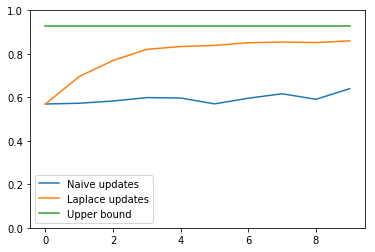

In [12]:
plt.plot(naive_loss_curve, label='Naive updates')
plt.plot(laplaced_loss_curve, label='Laplace updates')
plt.plot([upper_bound_curve for _ in naive_loss_curve], label='Upper bound')
plt.ylim([0, 1])

plt.legend()

### Conclusion

While the updated learning is not as good as the upper bound, we see it's way better than the naive approach. Moreover, after observing the entire dataset, it get pretty close to the good solution. Hence, it's a nice alternative when the it is infeasible/too expensive to learn on the entire dataset.